<a href="https://colab.research.google.com/github/dagyaom/Python_Practice/blob/main/%ED%8A%B8%EB%A6%AC%EB%AA%A8%EB%8D%B8%26ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.(의사)결정트리(Decision Trees)

- 파이프라인이 뭡니까?
- 결정트리는 뭡니까
- 특성중요도란?

- 결정트리 모델의 장점은? 선형회귀모델과 비교해서 어떠한가.
- 결정트리 생성할 떄 분기는 어떻게 정하게 되는가?


## Merge사용한 데이터 불러오기
- 나누어진 feature와 target을 합한다. 

In [ ]:
import pandas as pd

In [ ]:
train_1 = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv')
train_1.head(3)

In [ ]:
train_2 = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')
train_2.head(3)

In [ ]:
# 데이터 가져오기
target = 'vacc_h1n1_f'
train1 = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'),
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
train1.head(3)

# 왼쪽 데이터프레임의 인덱스를 조인키로 사용함.

In [ ]:
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
test.head(3)

In [ ]:
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')
sample_submission.head(3)

## EDA(탐색적 데이터분석)

In [ ]:
# 전체적인 형태 파악
train1.head().T

In [ ]:
# 컬럼 타입 파악
train1.dtypes

### 훈련/검증/테스트 데이터로 나누기

In [ ]:
# 전처리

from sklearn.model_selection import train_test_split

train, val = train_test_split(train1, train_size=0.80, test_size=0.20, 
                              stratify=train1[target], random_state=2)


train.shape, val.shape, test.shape

#stratify : 지정한 Data의 비율을 유지한다. 예를 들어, Label Set인 Y가 25%의 0과 75%의 1로 이루어진 Binary Set일 때,
#  stratify=Y로 설정하면 나누어진 데이터셋들도 0과 1을 각각 25%, 75%로 유지한 채 분할된다.

# 출처: https://ebbnflow.tistory.com/126 [Dev Log : 삶은 확률의 구름]

# ★ stratify: default=None 입니다. classification을 다룰 때 매우 중요한 옵션값입니다. stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지해 줍니다. 
#(한 쪽에 쏠려서 분배되는 것을 방지합니다) 만약 이 옵션을 지정해 주지 않고 classification 문제를 다룬다면, 성능의 차이가 많이 날 수 있습니다.
# 계층적 데이터 추출 옵션 (분류 모델에서 추천!)
# : 여러 층으로 분할후 각 층별로 렌덤 데이터 추출, 원래 데이터의 분포와 유사하게 데이터 추출
#https://teddylee777.github.io/scikit-learn/train-test-split

### 타겟비율

In [ ]:
train1[target].value_counts(normalize=True)

In [ ]:
# 타겟 비율 살펴보기
print(train[target].value_counts(normalize=True))
print(val[target].value_counts(normalize=True))

# stratify=train1[target] -- 이 옵션을 줌으로써 train1의 타겟값 비율이 train과 val에 동일하게 적용되었음을 알 수 있다. 
# 클래스가 0,1인 분류문제로, 가장 큰 범주(0)dl 76%가량을 차지하고 있다. --> 클래스가 불균형한 분류문제(imbalanced)

### 프로파일링을 이용한 EDA

In [ ]:
# 프로파일링을 사용해서 데이터리포트를 분석해보자
# pip install pandas-profiling   #이 셀안에 글자적으면 실행안됨.


# out : SyntaxError: invalid syntax

# 설명 : https://github.com/pandas-profiling/pandas-profiling
# 공식문서 : https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/

In [ ]:
# pip install -U pandas-profiling

In [ ]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(train).to_notebook_iframe()

# #profile = df.profile_report() 이런 형태도 가능
# # 좀 더 간략하고 빠르게 보고싶다면  ProfileReport(train, minimal=True) 옵션을 지정한다. --> overview와 Variables까지만 나옴.



In [ ]:
# 내보내기
# ProfileReport(train).to_file("your_report.html")

In [ ]:
# warning의 대부분이 결측치에 대한 것임을 알 수 있다. 
# Impute를 사용할 것을 생각해두자.
# dtypes로 하였을 때 실수형이 많았는데, 리포트에는 실수형이 거의 없었다. 어찌된 일인가 알아보자.

### 프로파일링과 비교

In [ ]:
# 실수 형태만 데이터에서 빼내기 : select_dtypes('')
train.select_dtypes('float').head(5).T

# 실수형이지만, 실제로는 범주형이나 이진형 특성들이구나. 

### 중복값 확인

In [ ]:
# 중복값도 있는지 알아보자
train.T.duplicated()

### 카디널리티 알아보기

In [ ]:
# 너무 많은 범주 처리:cardinality --> 유일값이 몇개인지 볼 것.
train.describe(exclude='number')

#exclude='' : 결과에서 생략할 데이터 유형의 블랙리스트. 숫자 유형을 제외하려면 numpy.number를 제출하십시오.

In [ ]:
# 디폴트와 비교
train.describe()

In [ ]:
train.describe(exclude='number').T.sort_values(by='unique')

# state 카디널리티가 너무 높아서 조정을 해줘야겠다..!

In [ ]:
# 카테고리를 많이 가지는 특성의 범주도 살펴보자
train['employment_occupation'].value_counts()  #유일값별 갯수세기

## Feature Engneering

In [ ]:
import numpy as np

def engineer(df):
    #높은 카디널리티 제거
    selected_cols = df.select_dtypes(include=['number', 'object'])   # df에서 number와 object유형인 feature를 전부 뽑아낸다.(사실 이 데이터에서는 전부다임)
    labels = selected_cols.nunique()
    selected_features = labels[labels<=30].index.tolist()
    df = df[selected_features]

    #새로운 특성 생성
    #컬럼에서 behavioral 관련 특성 뽑아서 합계한 하나의 특성을 만들기
    behaviorals = [col for col in df.columns if 'behavioral' in col]
    df['behaviorals'] = df[behaviorals].sum(axis=1)

    #seas 컬럼은 제거
    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace = True)

    return df

# train = engineer(train)
# val = engineer(val)
# teste = engineer(test)

### 피쳐엔지니어링 연습

In [ ]:
#1) nunique()  vs .unique()
labels1 = train.nunique()  #nunique()는 컬럼별로 유일값 갯수를 세어주는 것.
labels1

In [ ]:
train['employment_occupation'].unique()

# unique()는 어레이배열에서 유일값을 빼주는 것.
# 만약 어레이 배열에서 유일값 갯수를 세고싶다면 value_counts() 메서드를 써야 한다.

In [ ]:
#2) 
labels1[labels1 <=30]  #state가 빠짐.

In [ ]:
select = labels1[labels1 <=30].index # 유일값이 30보다 작은 것만 뽑아서, 어레이 배열의 인덱스를 꺼낸다. 
select

In [ ]:
# 그걸 다시 list로 만든다 ★ 굳이 왜 만든건지 모르겠넹
select1 = labels1[labels1 <=30].index.tolist()
select1

In [ ]:
train_sl=train[select1]
train_sl.head()

In [ ]:
a=[]
for col in train_sl.columns:
    if 'behavioral' in col :
        a.append(col)
    
print(a)

# --> 축약하면
# --> [col for col in train_sl.columns if 'behivioral' in col]

In [ ]:
train_sl[a].head()

In [ ]:
train_sl[a].sum()

In [ ]:
train_sl[a].sum(axis=1)

In [ ]:
train[select].head()

### 연습 끝!

In [ ]:
# 함수 적용해서 특성공학 완료
train = engineer(train)
val = engineer(val)
test = engineer(test)

## PreProcessing(전처리)

### 특성/타겟 분리하기

In [ ]:
target = 'vacc_h1n1_f'
features = train.drop(columns = [target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

### Pipelines : 전처리+모델링(LogisticRegression)
- 중복코드의 최소화로 여러 모델을 같은 전처리 프로세스에 연결시킨다.

전처리: OneHotEncoder(),     SimpleImputer(),    StandardScaler(),


https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
https://woolulu.tistory.com/79

In [ ]:
pip install --upgrade category_encoders

In [ ]:
# 파이프라인에 넣어도 다 import해 줘야됨 
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [ ]:
pipe = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(n_jobs=-1)
)
pipe.fit(X_train, y_train)

print('검증세트 정확도', pipe.score(X_val,y_val))  #변환을 적용하고 최종 추정기로 점수를 매깁니다.(predict까지 들어가있음) 

y_pred = pipe.predict(X_test)

n_jobs=-1

n_jobs = int, default=None
Number of CPU cores used when parallelizing over classes if multi_class=’ovr’”. This parameter is ignored when the solver is set to ‘liblinear’ regardless of whether ‘multi_class’ is specified or not. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.

### 파이프라인 스텝접근

- named_steps 은 유사 딕셔너리 객체(dictionary-like object)로 파이프라인 내 과정에 접근 가능하도록 합니다.



In [ ]:
# 파이프라인에서 각 스텝에 접근하기
# https://scikit-learn.org/stable/modules/compose.html#accessing-steps

In [ ]:
pipe.named_steps #각 스텝에 접근하게 해주는 메서드

In [ ]:
%%time
print('Shape before: ', X_train.shape)
# OneHotEncoder
enc = pipe.named_steps['onehotencoder']
encoded = enc.transform(X_train)
print('OneHot shape: ', encoded.shape)

In [ ]:
import matplotlib.pyplot as plt

enc = pipe.named_steps['onehotencoder']
encoded_columns = enc.transform(X_val).columns #원핫인코딩한 후에 X_val의 칼럼을 빼낸다.

model_lr = pipe.named_steps['logisticregression'] 
coefficients = pd.Series(model_lr.coef_[0], encoded_columns) # 인덱스를 아까빼낸 칼럼에서 가져오고, 로지스틱회귀의 계수를 빼내서 시리즈로 만들자.

plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh();  #만든 시리즈를 값이 계수가 큰 순서대로 정렬해서, 수평plot으로 만들어

# 0이 아무 상관관계도 없는거. -는 음의 상관관계, +는 양의 상관관계.
# 상관계수 해석 : https://ko.wikipedia.org/wiki/%EC%83%81%EA%B4%80_%EB%B6%84%EC%84%9D

# 1. Decision Tree 드디어 결정트리의 학습

https://wooono.tistory.com/104 참고

## Decision Tree 의 정의

-  특정 기준(질문)에 따라 데이터를 구분하는 모델

- 특성들을 기준으로 샘플을 분류하는데, 결과 모델이 Tree 구조를 가지고 있기 때문에 Decision Tree라는 이름을 가진다. 스무고개하듯 특성들의 수치를 가지고 질문을 통해 정답 클래스를 찾아가는 과정이다. 데이터를 분할해가는 알고리즘.

\
룰 기반 모델
- distance-based model    vs    rule-based model
- distance : 거리. error를 기준으로 하는 모델. (다양한 회귀모델이 이에 해당)
- rule : 하나의 노드 지날 때마다 룰1, 룰2... 룰 기반 모델이 바로 결정트리모델.
- 분류, 회귀 둘다 가능

- 말단의 정답을 노드(node) 질문이나 정답을 의미.
- 노드를 연결하는 선을 엣지(edge)
- root노드, internal노드, leaf/external, terminal노트로 나뉜다. (뿌리, 중간, 말단)
- 결정 트리의 기본 아이디어는, Leaf Node가 가장 섞이지 않은 상태로 완전히 분류되는 것, 즉 복잡성(entropy)이 낮도록 만드는 것

\
- 장점 : 
1) 직관적인 해석이 가능. 다중공선성의 영향을 덜받는다.(그러나 전처리는 완벽해야 한다) \
2) 선형모델과 달리 비선형, 비단조(non-monotonic), 특성상호작용(feature interactions) 특징을 가지고 있는 데이터 분석에 용의
- 단점 : 과적합.

```
# 특성상호작용
특성상호작용은 특성들끼리 서로 상호작용을 하는 경우를 말함.
회귀분석에서는 서로 상호작용이 높은 특성들이 있으면 개별 계수를 해석하는데 어려움이 있고 학습이 올바르게 되지 않을 수 있다.
하지만 트리모델은 이런 상호작용을 자동으로 걸러냄
```

```
# 다중공선성
다중공선성은 독립변수들 간에 강한 상관관계가 나타나서,
회귀분석의 전제가정인 독립변수들 간에 상관관계가 높으면 안된다는 조건을 위배하는 경우를 의미합니다
```

<img src="https://gdcoder.com/content/images/2019/05/Screen-Shot-2019-05-18-at-03.40.41.png" width="600" />

## 분할 방법

Leaf Node가 가장 섞이지 않은 상태로 완전히 분류되는 것, 즉 복잡성(entropy)이 낮도록 만드는 것

I say >> 어떤 특성으로 분류했을 떄, 타겟의 불순도를 가장 낮게 해주는 특성부터 가지치기를 한다. 

\
- 복잡성이 낮아지려면 중요한 것은 더 중요한 특성을 앞쪽에서 가지 쳐 주는 것.
- 더 중요한 특성 = 타겟이 더 확실히 구분이 되는 특성 = 불확실성을 낮춰주는 특성 = 자식노드에서 불순도가 낮아지는 특성
- 한번의 분기 때마다 변수 영역을 두 개로 구분

\
- 즉, 결정트리 학습 = 노드를 어떻게 분할하는가에 대한 문제.
- 트리모델 학습 알고리즘 = 결정트리의 비용함수를 최소화하도록 분할하는 것. 
- 즉, 노드를 분할하는 시점에서 가장 비용함수를 줄이는 분할특성과 분할지점을 찾아 내는 프로세스가 필요
- 결정트리에서 비용함수란? 그래서 어떻게 분할할건데?




### Impurity(불순도)
- 결정트리에서 분기기준선택을 위해 불순도라는 개념 사용
- 불순도 = 복잡성. 해당 범주 안에 서로 다른 데이터가 얼마나 섞여 있는가를 의미.
- 다양한 개체가 섞일 수록 불순도가 높아진다. 

예를들어 A, B 두 클래스가 혼합된 데이터가 있을 때 (A, B) 비율이

(45%, 55%)인 샘플(두 범주 수가 비슷)은 불순도가 높은 것이며 \
(80%, 20%)인 샘플이 있다면 상대적으로 위의 상태보다 불순도가 낮은 것(순수도(purity)는 높음)=순수하다.

\
- 분기기준 설정 시 현재노드의 불순도에 비해 자식노드의 불순도가 감소되도록 설정해야 함. 

- 현재 노드 불순도와 자식노드 불순도 차이를 **Information Gain(정보 획득)**이라고 함.
- information gain = base entropy - new entropy(분기이전 분순도 - 분기이후 불순도)
- 불순도가 1인 상태에서 0.7인 상태로 바뀌었다면 정보 획득(information gain)은 0.3

### 불순도 함수(Gini, Entropy)(비용함수)

- 불순도를 수치적으로 나타낼 수 있는 대표적인 함수는 두가지가 있다. 
- 지니불순도(Gini Impurity or Gini Index): 최대값은 0.5

$${\displaystyle {I}_{G}(p)=\sum _{i=1}^{J}p_{i}(1-p_{i})=1-\sum _{i=1}^{J}{p_{i}}^{2}}$$


- 엔트로피(Entropy):  불확실성의 정도
> binary의 경우 최대 엔트로피 1
  - 1 : 불확실성이 높다 ( 50:50) -->엔트로피가 가장 높은 비율
  - 0 : 불확실성이 낮다.( 100 :0)
  - 0.45 : {90:10)

 > 8개의 경우 : 2의 3승 --> 0<=N<=3 최대 엔트로피 3 \
 > 16개 데이터의 경우 : 2의 4승 --> 최대 엔트로피 4
 
$${\displaystyle \mathrm {H} (T)=\operatorname {I} _{E}\left(p_{1},p_{2},...,p_{J}\right)=-\sum _{i=1}^{J}{p_{i}\log _{2}p_{i}}}$$


- 엔트로피가 조금 더 균형잡힌 트리를 만들지만 지니불순도가 계산이 조금 더 빨라서 디폴트로 씀.


### 결정트리 구성 단계

1) Root 노드의 불순도 계산 \
2) 나머지 속성에 대해 분할 후 자식노드의 불순도 계산 \
3) 각 속성에 대한 Information Gain 계산 후 Information Gain(Root노드와 자식노드의 불순도 차이)이 최대가 되는 분기조건을 찾아 분기 \
4) 모든 leaf 노드의 불순도가 0이 될때까지 2,3을 반복 수행한다.


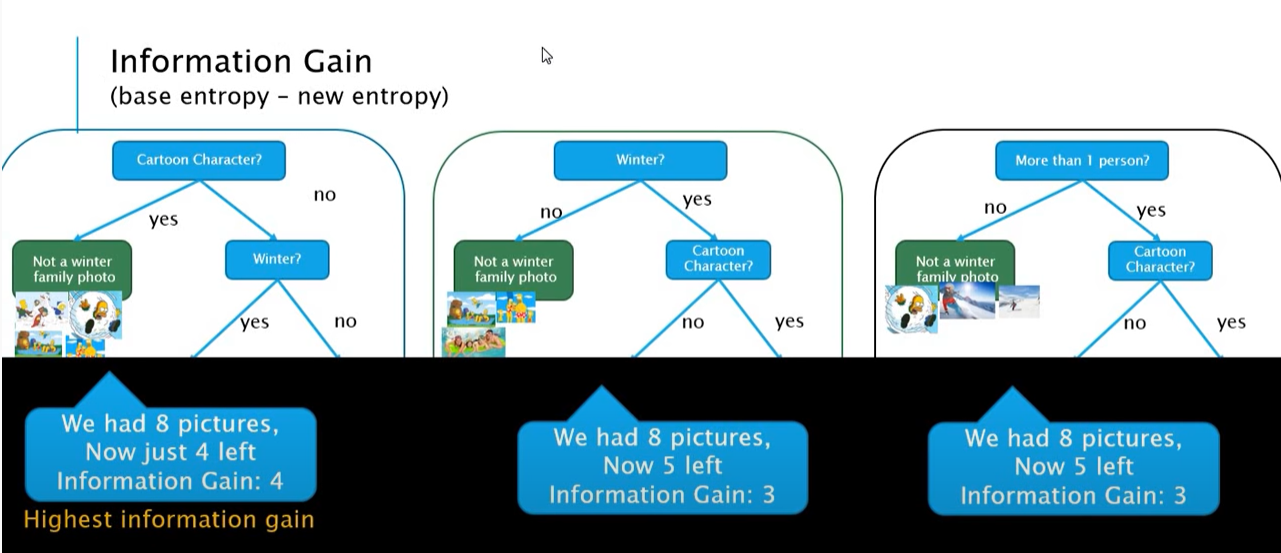

## 일반화

- 위 구성방법을 사용하여 트리를 형성하게 되면, leaf노드가 순도 100%의 한가지 범주만을 가지게 되는 Full tree(최대트리)를 형성하게 된다. 
- 이러한 최대트리는 새로운 데이터에 적용할 떄 과적합 문제(Overfitting)이 발생. --> 일반화 성능 떨어진다.
- 하이퍼파라미터 조합을 통해 일반화 성능 높이기.

## 사이킷런 : 분류 의사결정트리(DecisionTreeClassifier)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html




결정트리에서는 StandardScaler는 도움이 되지 않기 때문에 제외하고 학습

```
하나의 요인으로 구별하기 때문에 스케일을 맞춰줄 필요가 없다.
기준선을 가지고 데이터를 분할하는 과정이기 떄문.
```

In [ ]:
from sklearn.tree import DecisionTreeClassifier

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),  
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=1, criterion='entropy')   #엔트로피를 기준으로.
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))  #Classifier 에서는 accuracy 를 반환한다. 
print('검증 정확도: ', pipe.score(X_val, y_val))

y_val.value_counts(normalize=True)

# 과적합임을 알수있다. 
# 훈련 정확도:  0.9908667674880646
# 검증 정확도:  0.7572055509429486

# 0    0.761001
# 1    0.238999  # 기준모델과 비교해서 좋은지 나쁜지 비교.

## 결정트리 시각화

https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

https://ssoondata.tistory.com/14
https://velog.io/@ljs7463/%ED%8A%B9%EC%84%B1%EC%A4%91%EC%9A%94%EB%8F%84 특성중요도

In [ ]:
# graphviz 설치방법: conda install -c conda-forge python-graphviz
import graphviz
from sklearn.tree import export_graphviz   #트리확인

model_dt = pipe.named_steps['decisiontreeclassifier']
enc = pipe.named_steps['onehotencoder']

encoded_columns = enc.transform(X_val).columns

dot_data = export_graphviz(model_dt
                          , max_depth=3  #트리깊이는 3
                          , feature_names=encoded_columns
                          , class_names=['no', 'yes']  # 숫자 오름차순(순서대로)으로 각 대상 클래스의 이름입니다. 분류에만 관련되며 다중 출력에는 지원되지 않습니다. True이면 클래스 이름의 상징적 표현을 표시합니다.
                          , filled=True        # True로 설정하면 분류를 위한 대다수 클래스, 회귀를 위한 값의 극단 또는 다중 출력을 위한 노드의 순도를 나타내기 위해 노드를 색칠함.
                          , proportion=True)  #'값' 및/또는 '샘플'의 표시를 각각 비율 및 백분율로 변경합니다
  

display(graphviz.Source(dot_data))

# 특성들 중에서 전체 데이터에 대해 불순도(여기서는 엔트로피, default 지니)가 가장 크게 감소할 수 있는 가장 중요한 특성을 뽑는다.
# 0.62라는 값이 결정된 건, 그 특성 안에서 불순도가 가장 크게 감소할 수 있는 수치. 
# doctor_recc_hlnl 특성으로 분류했을 떄, 불순도는 0.793으로 불순도가 높음.(데이터가 50:50에 근접함)
# 0.62를 기준으로 100%의 샘플은 0.62보다 작은 수 76.1%(True), 0.62보다 큰 수 23.9%(False)로 나뉘어짐. 
# doctor_recc_hlnl라는 피쳐의 전체적인 클래스는 no.
# 그 이유는 export_graphviz를 그릴 때 클래스 네임을 0은 no, 1은 yes로 정해줬기 때문.
# 즉, doctor_recc_h1n1 <= 0.62가 맞으면 0, 아니면 1
# 여기서는 0.62보다 작은 value가 많으므로(즉, 맞다(0)이 많으므로) class는 no로 표현됨.


## 과적합 해결

https://injo.tistory.com/15

하이퍼파라미터 튜닝을 통해 의도적으로 regulazation(정규화)을 해준다.
- min_samples_split : 갈라치기 할때 최소샘플 수. =6으로 설정되었다면, 리프노트에 샘플수가 5이하부터는 가지치기 못함.
- min_samples_leaf : 리프 노드에 있어야 하는 최소샘플 수. =6으로 설정되었는데 리프노드에 샘플수가 6일 경우, 더이상 가지치기 안함.
- max_depth : 최대한의 깊이

```
DecisionTreeClassifier(min_samples_leaf=10, random_state=2)
```

## feature importance(특성중요도) 알아보기

특성 & 타겟 관계 파악할 때
- 선형모델 : 회귀계수(coefficients)로 파악
- 결정트리 : 특성중요도 확인(항상 양수값을 가짐)

이 값을 통해 특성이 얼마나 일찍, 얼마나 자주 분기에 사용되는지 결정된다. 
지니계수 or 엔트로피지수로 파악됨.

```
property feature_importances_¶
Return the feature importances.

The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values). See sklearn.inspection.permutation_importance as an alternative.

Returns
feature_importances_ndarray of shape (n_features,)
Normalized total reduction of criteria by feature (Gini importance).
```

In [ ]:
model_dt = pipe.named_steps['decisiontreeclassifier'] #파이프라인에서 꺼내기.

In [ ]:
enc = pipe.named_steps['onehotencoder']
encoded_columns = enc.transform(X_val).columns 

importance = pd.Series(model_dt.feature_importances_, encoded_columns)  ## 속성 feature_importances_ : 전체 특성들의 합이 1이 되도록 정규화되어 있음
importance.sort_values(ascending=False)  #시리즈 반환

# 그럼 여기서 트리 깊이를 어디까지 들어가야 할지 알수 있겠네??★

In [ ]:
# 시각화
plt.figure(figsize=(10,30))
importance.sort_values().plot.barh();

왜 굳이 원핫인코딩한 컬럼을 꺼내는가?

차이를 보자.

```
**X_val.columns**
Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'chronic_med_condition',
       'child_under_6_months', 'health_insurance', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'agegrp', 'education_comp', 'raceeth4_i',
       'sex_i', 'inc_pov', 'marital', 'rent_own_r', 'census_region',
       'census_msa', 'n_adult_r', 'household_children', 'n_people_r',
       'hhs_region', 'behaviorals'],
      dtype='object')
```
```
***enc***
OneHotEncoder(cols=['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
                    'opinion_h1n1_sick_from_vacc', 'agegrp', 'census_msa'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', return_df=True, use_cat_names=True,
              verbose=0)
```
```
**encoded_columns**
Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'chronic_med_condition',
       'child_under_6_months', 'health_insurance', 'health_worker',
       'opinion_h1n1_vacc_effective_1', 'opinion_h1n1_vacc_effective_2',
       'opinion_h1n1_vacc_effective_3', 'opinion_h1n1_vacc_effective_4',
       'opinion_h1n1_vacc_effective_5', 'opinion_h1n1_vacc_effective_6',
       'opinion_h1n1_vacc_effective_7', 'opinion_h1n1_risk_1',
       'opinion_h1n1_risk_2', 'opinion_h1n1_risk_3', 'opinion_h1n1_risk_4',
       'opinion_h1n1_risk_5', 'opinion_h1n1_risk_6', 'opinion_h1n1_risk_7',
       'opinion_h1n1_sick_from_vacc_1', 'opinion_h1n1_sick_from_vacc_2',
       'opinion_h1n1_sick_from_vacc_3', 'opinion_h1n1_sick_from_vacc_4',
       'opinion_h1n1_sick_from_vacc_5', 'opinion_h1n1_sick_from_vacc_6',
       'opinion_h1n1_sick_from_vacc_7', 'agegrp_1', 'agegrp_2', 'agegrp_3',
       'agegrp_4', 'agegrp_5', 'agegrp_6', 'agegrp_7', 'education_comp',
       'raceeth4_i', 'sex_i', 'inc_pov', 'marital', 'rent_own_r',
       'census_region', 'census_msa_1', 'census_msa_2', 'census_msa_3',
       'n_adult_r', 'household_children', 'n_people_r', 'hhs_region',
       'behaviorals'],
      dtype='object')
```


## 특성상호작용과 회귀 의사결정트리
https://christophm.github.io/interpretable-ml-book/interaction.html#feature-interaction

- 특성들 끼리 서로 상호작용을 하는 경우를 말함. 
- 예를들면, 기본가격15만원에 위치가 좋을경우 +5만원(나쁠경우 0), 크기가 클 경우 +10만원(작을 경우 0)이 되는 특성을 가진 데이터가 있다고 했을 때, 만약 두 가지 특성을 모두 가지고 있을 때 +10만원 규칙이 추가되면서 타겟값에 더 큰 영향을 미치게 되는 것이 특성 상호작용.

#### 특성 상호작용 없을 때

In [ ]:
import pandas as pd
cols = ['location','size','price']
# location: 1:good, 0:bad
# size: 1:big, 0:small
# big은 small보다 100,000 비싸고, good은 bad보다 50,000 가격이 더 나갑니다.
features = [[1, 1], 
            [1, 0], 
            [0, 1], 
            [0, 0]]

price = [[300000], 
        [200000], 
        [250000], 
        [150000]]

X_house = pd.DataFrame(columns=cols[:2], data=features)
y_house = pd.DataFrame(columns=[cols[2]], data=price)

In [ ]:
X_house

In [ ]:
y_house

In [ ]:
# 선형회귀 모델 만들기

from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X_house, y_house)
print('R2: ', linear.score(X_house, y_house))
print('Intercept: ', linear.intercept_[0])  #절편
print('Coefficients')  #계수
pd.DataFrame(columns=cols[:2], data=linear.coef_)

In [ ]:
import graphviz
## jupyterlab 사용시: jupyter labextension install @jupyter-widgets/jupyterlab-manager
from ipywidgets import interact
from sklearn.tree import DecisionTreeRegressor, export_graphviz

# 트리구조 그리는 함수
def show_tree(tree, colnames):
    dot = export_graphviz(tree, feature_names=colnames, filled=True, rounded=True)   
    return graphviz.Source(dot)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(criterion="mae")  #회귀의사결정트리이며, 분할할 때 절대제곱오차를 기준으로 한다. 
tree.fit(X_house, y_house)
print('R2', tree.score(X_house, y_house))  #

show_tree(tree, colnames=X_house.columns)

#### 특성상호작용 있게 하면?

In [ ]:
# 특성상호작용 만들어주기
y_house.loc[0, 'price'] = 400000  #행, 열 순서로 넣어줌 index명과, columns
y_house

# 의도적으로 +100000을 해줬다. 

In [ ]:
# 성능감소
linear = LinearRegression()
linear.fit(X_house, y_house)
print('R2: ', linear.score(X_house, y_house))
print('Intercept: ', linear.intercept_[0])
print('Coefficients')
pd.DataFrame(columns=cols[:2], data=linear.coef_)

In [ ]:
# 성능 그대로. 문제없이 가격을 예측함.
tree = DecisionTreeRegressor(criterion="mae")
tree.fit(X_house, y_house)
print('R2', tree.score(X_house, y_house))
show_tree(tree, colnames=X_house.columns)

## 비선형 회귀에 적용한 의사결정트리

In [ ]:
columns = ['mobility', 'density']
data = [[80.574, -3.067]
,[84.248, -2.981]
,[87.264, -2.921]
,[87.195, -2.912]
,[89.076, -2.84]
,[89.608, -2.797]
,[89.868, -2.702]
,[90.101, -2.699]
,[92.405, -2.633]
,[95.854, -2.481]
,[100.696, -2.363]
,[101.06, -2.322]
,[401.672, -1.501]
,[390.724, -1.46]
,[567.534, -1.274]
,[635.316, -1.212]
,[733.054, -1.1]
,[759.087, -1.046]
,[894.206, -0.915]
,[990.785, -0.714]
,[1090.109, -0.566]
,[1080.914, -0.545]
,[1122.643, -0.4]
,[1178.351, -0.309]
,[1260.531, -0.109]
,[1273.514, -0.103]
,[1288.339, 0.01]
,[1327.543, 0.119]
,[1353.863, 0.377]
,[1414.509, 0.79]
,[1425.208, 0.963]
,[1421.384, 1.006]
,[1442.962, 1.115]
,[1464.35, 1.572]
,[1468.705, 1.841]
,[1447.894, 2.047]
,[1457.628, 2.2]]

thurber = pd.DataFrame(columns=columns, data=data)

# 데이터를 시각화 합니다.
thurber.plot('mobility', 'density', kind='scatter', title='Thurber');

In [ ]:
X_thurber = thurber[['mobility']]
y_thurber = thurber['density']
linear = LinearRegression()
linear.fit(X_thurber, y_thurber)
print('R2: ', linear.score(X_thurber, y_thurber))
ax = thurber.plot('mobility', 'density', kind='scatter', title='Thurber')
ax.plot(X_thurber, linear.predict(X_thurber));

In [ ]:
# max_depth를 더할 수록 선에 적합이 되어 비선형 데이터를 학습할 수 있음
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def thurber_tree(max_depth=1):      #깊이 1부터 시작.
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(X_thurber, y_thurber)
    print('R2: ', tree.score(X_thurber, y_thurber))
    ax = thurber.plot('mobility', 'density', kind='scatter', title='Thuber')
    ax.step(X_thurber, tree.predict(X_thurber), where='mid')  
    plt.show()
    display(show_tree(tree, colnames=['mobility']))

interact(thurber_tree, max_depth=(1,6,1));  #interact의 첫 번째 인수로 함수를, 이후의 인수로 함수의 인수를 전달한다. 이 "함수의 인수"에 1개의 값이 아닌 값의 범위를 전달한다
#from ipywidgets import interact : https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html

#ax.step() : matplotlib 관련메서드 : https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.step.html
#where='mid' : 계단모양이 X단계의 중간위치에서 생기게 함. 'pre'(default), 'post' 옵션이 있음.

# 2. Ensemble Learning-1. RandomForests

1. 랜덤포레스트는 결정트리와 어떻게 다른가?
- 결정트리의 단점 : 한 개의 트리만 사용하므로 한 노드에서 생긴 에러가 하부 노드에서도 계속 영향을 준다. and 트리의 깊이에 따라 과적합된다. 

2. 순서형인코딩(Ordinal encoding)과 원핫인코딩의 차이점은?

3. 범주형 변수의 인코딩 방법이 트리모델, 선형회귀모델에 주는 영향은 어떤것인가?

2. 배깅(Bagging)은 무슨 뜻?

3. Out-Of-Bag(OOB) sample의 역할은?

## 1) 앙상블 방법이란?
- 여러 개의 분류기를 생성하고, 그 예측을 결합함으로써 보다 정확한 예측을 도출하는 기법
- 강력한 하나의 모델을 사용하는대신 보다 약한 모델 여러개를 조합하여 더 정확한 예측에 도움을 주는 방식
- 비유 ) 어려운 문제를 해결하는데 한 명의 전문가보다 여러명의 집단지성을 이용하여 문제를 해결하는 방식

## 앙상블 학습 유형
- 보팅(Voting) : **여러 개의 분류기**가 투표를 통해 최종 예측 결과를 결정하는 방식. 
- 배깅(Bootstrap AGGregatING, Bagging) : 데이터샘플링(Bootstrap)을 통해 모델을 학습시키고 결과를 집계(Aggregating)하는 방법. **같은 유형의 알고리즘 분류기** 사용. 랜덤포레스트가 해당.
- 부스팅(Boosting) : 여러개의 분류기가 순차적으로 학습 수행. 이전 분류기가 예측이 틀린 데이터에 대해서 올바르게 예측할 수 있도록 다음 분류기에게 가중치(weight)를 부여하면서 학습과 예측을 진행.  XGBoost, LightGBM

http://www.dinnopartners.com/__trashed-4/

https://itwiki.kr/w/%EC%95%99%EC%83%81%EB%B8%94_%EA%B8%B0%EB%B2%95





## 2) 부트스트랩(Bootstrap) 샘플링
- 원본 데이터에서 샘플링을 하는데 복원추출하는 방식. (샘플을 뽑아 값을 기록하고 제자리에 돌려놓는 것. )
- 이렇게 얻은 샘플을 '부트스트랩 세트'라고 하며, 이것으로 작은 모델들이 학습을 함. 
- 부트스트랩 세트에는 같은 샘플이 반복될 수 있다. (복원추출이므로)

- **Out Of Bag** 샘플 : 부트스트랩 샘플링 시에 추출되지 않은 나머지 샘플. (표본의 약 36.8%) 이 샘플로 모델검증이 가능하다.
```
# oob 샘플로 검증하기
pipe.named_steps['randomforestclassifier'].oob_score_
```


## 3) Aggregation
- 부트스트랩 세트로 만들어진 기본모델들(weak learner)을 합치는 과정.
- 회귀 : 기본모델 결과들의 평균값
- 분류 : 다수결로 결정 - 가장 많은 모델들이 선택한 범주로 예측

## 4) weak model에 사용될 트리 만드는 방법
- 의사결정트리 : 모든 특성을 고려해서 최적의 특성 = 가장 불순도를 낮춰주는 특성(특성 중요도가 가장 높은 특성)으로 분할.
- 랜덤포레스트 : 특성 n개 중에서 일부분 k개 특성을 랜덤선택해서, k개에서 최적의 특성을 찾아내서 분할함. (k개 = $log_2 n$)

## 5) 트리 앙상블 모델이 결정트리모델보다 과적합 피할 수 있는 이유
1. 각 기본트리에 사용되는 데이터는 랜덤으로 선택된다.
2. 각 기본트리는 무작위로 선택된 특성을 가지고 분기를 수행한다. 

이렇게 랜덤하게 샘플링된 데이터로 과적합된 트리를 많이 만들고, 그 결과를 평균내어 사용함으로써 과적합을 줄이고 성능을 유지한다. 

## 6) 원핫인코딩 vs 순서형 인코딩(Ordinal)

- 트리구조 학습에서는 원핫인코딩을 사용하면 문제가 된다. 왜?
- 트리구조에서는 중요한 특성에 대해 상위노드에서 먼저 분할이 일어난다. 그런데 high cardinality(범주 종류가 많은 특성) 특성을 원핫인코딩 하게되면 상위노드에서 선택될 기회가 적어진다. ★
- 그래서 원핫인코딩 영향을 안 받는 수치형 특성들이 상위노드를 차지할 기회가 높아지고 전체적인 성능저하가 생길 수 있다. 
- but! 순서형인코딩은 주의해야 할 것이 있습니다. 범주들을 순서가 있는 숫자형으로 바꾸면 원래 그 범주에 없던 순서정보가 생깁니다. 만약 무작위로 숫자로 범주를 맵핑하게 되면 의미를 알아내기 어려워서 정확도도 낮아집니다. 
- 순서형 인코딩은 범주들 간에 분명한 순위가 있을때 그 연관성에 맞게 숫자를 정해주는 것이 좋습니다. 예를들어 영화 평점과 같은 특성은 분명히 순서형 인코딩이 적절합니다.
- 정확한 범주의 순위를 알고 있다면 mapping 파라미터를 사용해 지정해줄 수 있습니다. https://github.com/scikit-learn-contrib/category_encoders/issues/228


- 결론 : 분류문제에서는 순서형 인코딩을 해도 상관없다. 트리모델에서는 순서의 숫자가 상관이없이때문에 괜찮다. 그런데 선형모델엥서는 정확도가 많이 떨어진다. ★

- 카테고리 인코딩 : https://data-newbie.tistory.com/578
https://brendanhasz.github.io/2019/03/04/target-encoding

In [ ]:
# 이번엔 높은 카디널리티 특성인 state를 그대로 살려서 처리해보자.
def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 높은 카디널리티를 가지는 특성을 제거합니다.
#     selected_cols = df.select_dtypes(include=['number', 'object'])
#     colnames = selected_cols.columns.tolist()
#     labels = selected_cols.nunique()
    
#     selected_features = labels[labels <= 30].index.tolist()
#     df = df[selected_features]
    
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    
    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

In [ ]:
%%time
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

In [ ]:
pip install --upgrade category_encoders

In [ ]:
%%time
from category_encoders import OrdinalEncoder
# ordinal encoding
pipe_ord = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=10, n_jobs=-1, oob_score=True)
)

pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))

# Wall time: 1.38 s -->원핫인코더보다 2배 빨라짐

In [ ]:
# 특성의 수 변화

print('Shape  before: ', X_train.shape)

# OneHotEncoder
enc = pipe.named_steps['onehotencoder']
encoded = enc.transform(X_train)
print('OneHot  shape: ', encoded.shape)

# OrdinalEncoder
enc = pipe_ord.named_steps['ordinalencoder']
encoded = enc.transform(X_train)
print('Ordinal shape: ', encoded.shape)

In [ ]:
# 특성 중요도 비교
import matplotlib.pyplot as plt

# 특성 중요도(onehot)
rf = pipe.named_steps['randomforestclassifier']
print(len(rf.feature_importances_))
print(rf.feature_importances_)  #랜덤 포레스트 분류기의 피쳐 중요도 꺼내기.
print('\n')

enc = pipe.named_steps['onehotencoder']
encoded_columns = enc.transform(X_val).columns  # X_val에 transform한 뒤 컬럼 빼내기
print(type(encoded_columns))
print(len(encoded_columns))
print(encoded_columns)
print('\n')

colnames = pipe.named_steps['onehotencoder'].get_feature_names()  #파이프에서 바로 피쳐네임 꺼내기
print(len(colnames))
print(type(colnames))
print(colnames)  # list로 반환

In [ ]:
importances = pd.Series(rf.feature_importances_, colnames)  #colnames를 인덱스로, rf.feature_importances_를 벨류로 해서, 시리즈 형태로 만들기.
importances

In [ ]:
n = 10
plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with onehotencoder')
importances.sort_values()[-10:].plot.barh(); #ascending=True 가 디폴트

# 특성 중요도(ordinal)
rf_ord = pipe_ord.named_steps['randomforestclassifier']
importances_ord = pd.Series(rf_ord.feature_importances_, X_train.columns)

plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with ordinalencoder')
importances_ord.sort_values()[-n:].plot.barh();

In [ ]:
importances.sort_values().plot.bar()  # sort_values() : 컬럼의 값을 기준으로 데이터를 정렬.디폴트 오름차순. 그런데 barh()로 표시하면 자동으로 거꾸로 정렬됨. 그래서 [-n:]

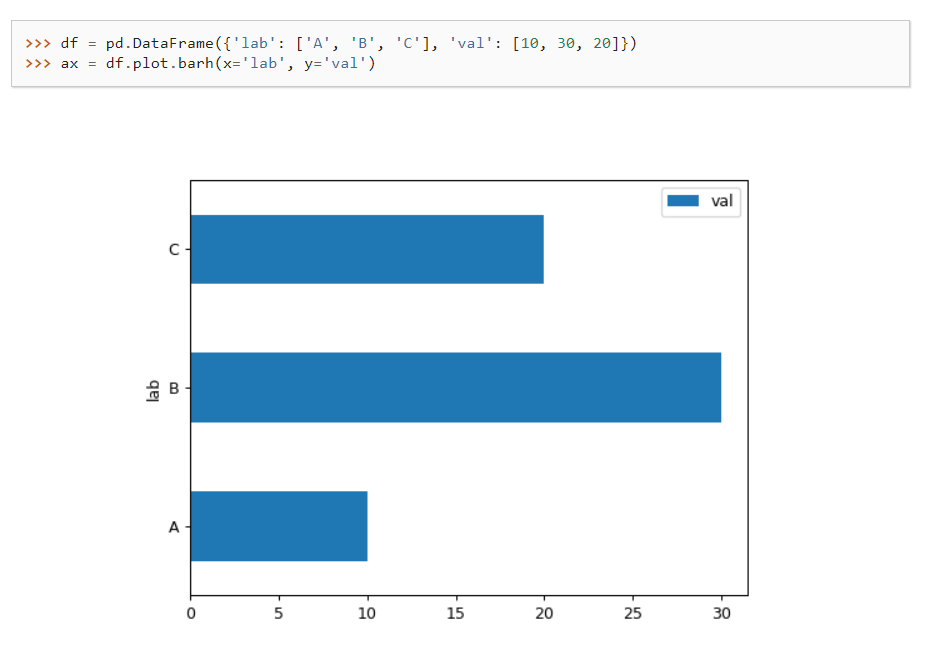

In [ ]:
columns = ['mobility', 'density']
data = [[80.574, -3.067]
,[84.248, -2.981]
,[87.264, -2.921]
,[87.195, -2.912]
,[89.076, -2.84]
,[89.608, -2.797]
,[89.868, -2.702]
,[90.101, -2.699]
,[92.405, -2.633]
,[95.854, -2.481]
,[100.696, -2.363]
,[101.06, -2.322]
,[401.672, -1.501]
,[390.724, -1.46]
,[567.534, -1.274]
,[635.316, -1.212]
,[733.054, -1.1]
,[759.087, -1.046]
,[894.206, -0.915]
,[990.785, -0.714]
,[1090.109, -0.566]
,[1080.914, -0.545]
,[1122.643, -0.4]
,[1178.351, -0.309]
,[1260.531, -0.109]
,[1273.514, -0.103]
,[1288.339, 0.01]
,[1327.543, 0.119]
,[1353.863, 0.377]
,[1414.509, 0.79]
,[1425.208, 0.963]
,[1421.384, 1.006]
,[1442.962, 1.115]
,[1464.35, 1.572]
,[1468.705, 1.841]
,[1447.894, 2.047]
,[1457.628, 2.2]]

thurber = pd.DataFrame(columns=columns, data=data)
X_thurber = thurber[['mobility']]
y_thurber = thurber['density']

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

def trees(max_depth=1, n_estimators=1):
    models = [DecisionTreeRegressor(max_depth=max_depth), 
              RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)] #n_estimators 기본모델의 갯수 조정
    
    for model in models:
        name = model.__class__.__name__   # model이름이 뭔지 말해주는 메서드
        model.fit(X_thurber, y_thurber)
        ax = thurber.plot('mobility', 'density', kind='scatter', title=name)
        ax.step(X_thurber, model.predict(X_thurber), where='mid')
        plt.show()
        
interact(trees, max_depth=(1,10,1), n_estimators=(10,50,10));

# n_estimators : https://tensorflow.blog/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/2-3-6-%EA%B2%B0%EC%A0%95-%ED%8A%B8%EB%A6%AC%EC%9D%98-%EC%95%99%EC%83%81%EB%B8%94/
# 트리의 갯수를 지정함.